In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import datetime, time

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

from google.cloud import bigquery
os.environ['GOOGLE_APPLICATION_CREDENTIALS']=f"/home/jovyan/.config/gcloud/legacy_credentials/{os.getenv('JUPYTERHUB_USER')}/adc.json" 

bq = bigquery.Client(project='gcp-wow-rwds-ai-mmm-prod')

### Incremental sales monitoring

In [3]:
sql = '''
    WITH foo AS (
        SELECT 
            campaign_start_date,
            crn, 
            Model,
            post_week_flag,
            SUM(IFNULL(weekly_inc_sales,0)) AS inc_sales
        FROM `gcp-wow-rwds-ai-mmm-prod.PROD_MMM.MMM_POST_BQ_MASTER_AUDIENCE` 
        WHERE campaign_start_date > '2020-07-01'
        GROUP BY 1,2,3,4
    )

    SELECT 
        campaign_start_date AS ds,
        model, 
        post_week_flag,
        COUNT(DISTINCT crn) AS N, 
        AVG(inc_sales) AS rpc, 
    FROM foo
    GROUP BY 1,2,3 
    ORDER BY 1,2,3;
'''

df = bq.query(sql).result().to_dataframe()

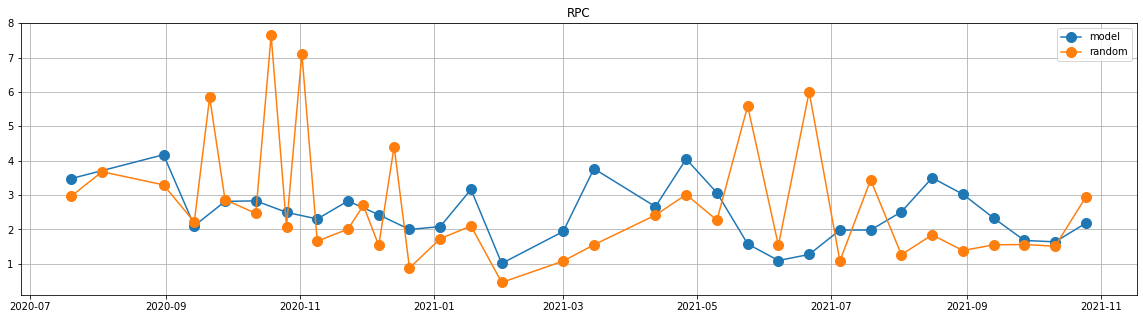

In [4]:
dfg = df.groupby(['ds','model']).aggregate({'rpc': 'sum'}).reset_index()

dfg_m = dfg[dfg.model=='M']
dfg_r = dfg[dfg.model=='R']

plt.figure(figsize=(20,5))
plt.title('RPC')
plt.plot(dfg_m.ds, dfg_m.rpc, '.-', label='model', ms=20)
plt.plot(dfg_r.ds, dfg_r.rpc, '.-', label='random', ms=20)
plt.legend()
plt.grid()
plt.show()

### Ratio analysis

We compute ratio of post-week incremental sales relative to promo-week incremental sales. The point is to normalise and answer the following question: For each $1 incremental sales in promo-week, what is the expected incremental sales in post-week. That way, we can compare different times better.

In [5]:
# model and random
df_m = df[df.model=='M']
df_r = df[df.model=='R']

# model: promo and post
df_m0 = df_m[df_m.post_week_flag==0]
df_m1 = df_m[df_m.post_week_flag==1]

# random: promo and post
df_r0 = df_r[df_r.post_week_flag==0]
df_r1 = df_r[df_r.post_week_flag==1]

# Calculate ratio between post-promo for model and random
df_mp = df_m0[['ds','rpc']].merge(df_m1[['ds','rpc']], left_on='ds', right_on='ds')
df_mp['rpc_ratio'] = df_mp['rpc_y'] / df_mp['rpc_x'] 

df_rp = df_r0[['ds','rpc']].merge(df_r1[['ds','rpc']], left_on='ds', right_on='ds')
df_rp['rpc_ratio'] = df_rp['rpc_y'] / df_rp['rpc_x'] 

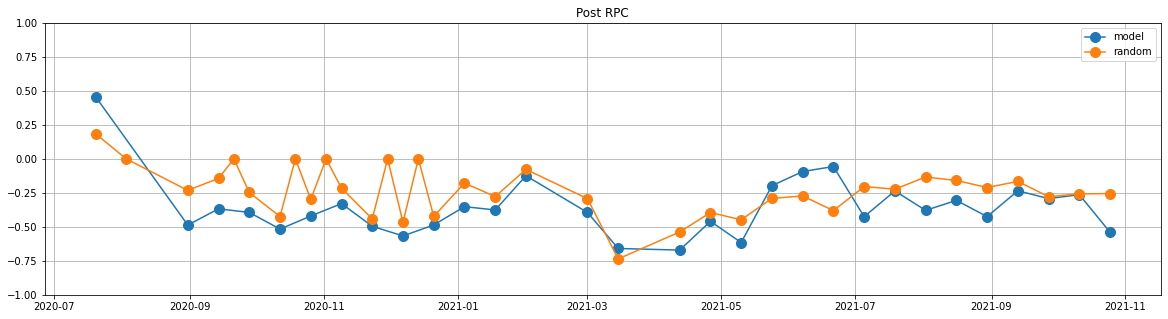

In [9]:
plt.figure(figsize=(20,5))
plt.title('Post RPC')
plt.plot(df_mp.ds, df_mp['rpc_y'], '.-', label='model', ms=20)
plt.plot(df_rp.ds, df_rp['rpc_y'] , '.-', label='random', ms=20)
plt.ylim(-1,1)
plt.legend()
plt.grid()
plt.show()

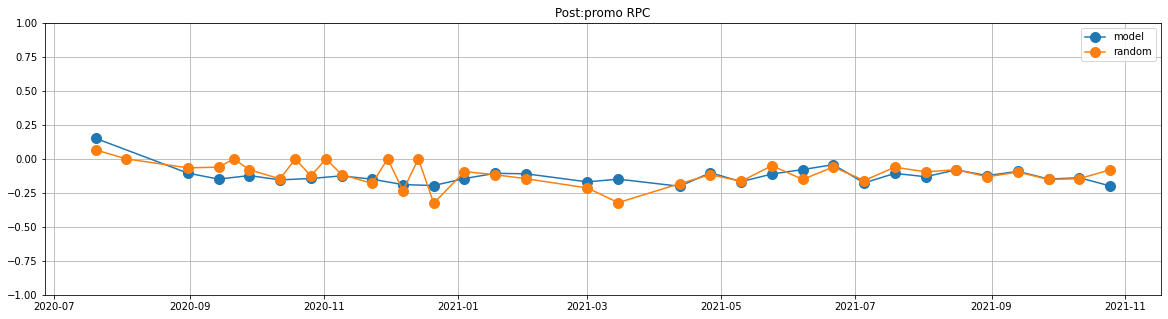

In [8]:
plt.figure(figsize=(20,5))
plt.title('Post:promo RPC')
plt.plot(df_mp.ds, df_mp['rpc_ratio'], '.-', label='model', ms=20)
plt.plot(df_rp.ds, df_rp['rpc_ratio'] , '.-', label='random', ms=20)
plt.ylim(-1,1)
plt.legend()
plt.grid()
plt.show()